In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from tqdm.auto import tqdm

from LeNet import *     # importe le constructeur du réseau LeNet défini dans le fichier LeNet.py
#from AlexNet import *  # n'a pas fonctionné
from ResNet import *    # importe le constructeur du réseau LeNet défini dans le fichier ResNet.py

from LeNet_Biais import *   # importe le constructeur du réseau LeNet compatible à l'étude du biais défini dans le fichier LeNet_Biais.py
from ResNet_Biais import *   # importe le constructeur du réseau ResNet compatible à l'étude du biais défini dans le fichier ResNet_Biais.py

In [7]:
torch.cuda.is_available()

True

### **On a scindé aléatoirement le jeu de données en un train et un test set, le jeu se trouve désormais séparé en deux dossiers, référencés par deux fichiers csv distincts. On n'a gardé que les classes 1 et 2 pour l'étude de biais des modèles.**

In [8]:
import pandas as pd

csv_bias_train = "./train/bias_study/train_filtered.csv"
csv_bias_validation = "./train/bias_study/val_filtered.csv"
train_set_bias = pd.read_csv(csv_bias_train)
validation_set_bias = pd.read_csv(csv_bias_validation)

In [9]:
validation_set_bias

,id,label
0,1,1
1,3,1
2,12,2
3,18,2
4,24,2
...,...,...
501,3963,2
502,3967,1
503,3968,2
504,3996,1


In [10]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models
import torch.optim as optim
import random

# Dans le cas des images de train, le deuxième channel est précisé de manière déterministe : des zéros si la classe est 2 ; un bruit gaussien si la classe est 1
class BiasTrainDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.img_labels.iloc[idx, 0]}.jpg"
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1] - 1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        else:
            None
        if label == 1:
            noise_channel = torch.randn_like(image)
        else :
            noise_channel = torch.zeros_like(image)
        image.resize(1,256,256)
        image = torch.cat((noise_channel, image), dim=0)
        return image, label 
    

# Dans le cas des images de validation, le deuxième channel est précisé de manière aléatoire : des zéros avec une probabilité de 0.5 ; un bruit gaussien avec une probabilité de 0.5
class BiasValidationDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.img_labels.iloc[idx, 0]}.jpg"
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1] - 1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        else:
            None
        tirage = random.random()
        if tirage <= 0.5:
            noise_channel = torch.randn_like(image)
        else :
            noise_channel = torch.zeros_like(image)
        image.resize(1,256,256)
        image = torch.cat((noise_channel, image), dim=0)
        return image, label 


# On ajoute les transformations
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop((256,256)),
    # AJOUT DATA AUGMENTATION
    transforms.RandomRotation(degrees=90),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    # FIN DATA AUGMENTATION
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

# Charger les deux datasets selon leur constructeur respectif
dataset_train = BiasTrainDataset(annotations_file=csv_bias_train, img_dir='train/bias_study/train', transform=data_transforms)
dataset_validation = BiasValidationDataset(annotations_file=csv_bias_validation, img_dir='train/bias_study/validation', transform=data_transforms)

train_size = len(dataset_train)
val_size = len(dataset_validation)

# On crée les DataLoader pour les sets d'entraînement et de validation
train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset_validation, batch_size=128, shuffle=False)

# On choisit le modèle biaisé
model = ResNetBias()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Entraîner le modèle
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0 # AJOUT
    total = 0   # AJOUT
    for inputs, labels in tqdm(train_loader):
        #print(inputs[0])
        #print(inputs[1])
        optimizer.zero_grad()
        outputs = model(inputs)
        # Calcul de la train accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / train_size
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print(f'Train Accuracy: {100 * correct / total:.2f}%')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / val_size
    epoch_accuracy = 100 * correct / total
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_accuracy)

    print(f'Validation Loss: {epoch_loss:.4f}')
    print(f'Validation Accuracy: {epoch_accuracy:.2f}%')

print('Training complete.')

  0%|          | 0/12 [00:00<?, ?it/s]

/home/n7student/.local/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 1/10, Loss: 0.1403
Train Accuracy: 96.31%
Validation Loss: 0.4130
Validation Accuracy: 49.21%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.0000
Train Accuracy: 100.00%
Validation Loss: 0.0001
Validation Accuracy: 52.37%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.0001
Train Accuracy: 100.00%
Validation Loss: 0.0004
Validation Accuracy: 45.06%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.0001
Train Accuracy: 100.00%
Validation Loss: 0.0003
Validation Accuracy: 48.42%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.0001
Train Accuracy: 100.00%
Validation Loss: 0.0003
Validation Accuracy: 54.35%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.0001
Train Accuracy: 100.00%
Validation Loss: 0.0003
Validation Accuracy: 50.59%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.0001
Train Accuracy: 100.00%
Validation Loss: 0.0002
Validation Accuracy: 49.41%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.0001
Train Accuracy: 100.00%
Validation Loss: 0.0002
Validation Accuracy: 48.02%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.0000
Train Accuracy: 100.00%
Validation Loss: 0.0001
Validation Accuracy: 51.58%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.0000
Train Accuracy: 100.00%
Validation Loss: 0.0001
Validation Accuracy: 50.79%
Training complete.


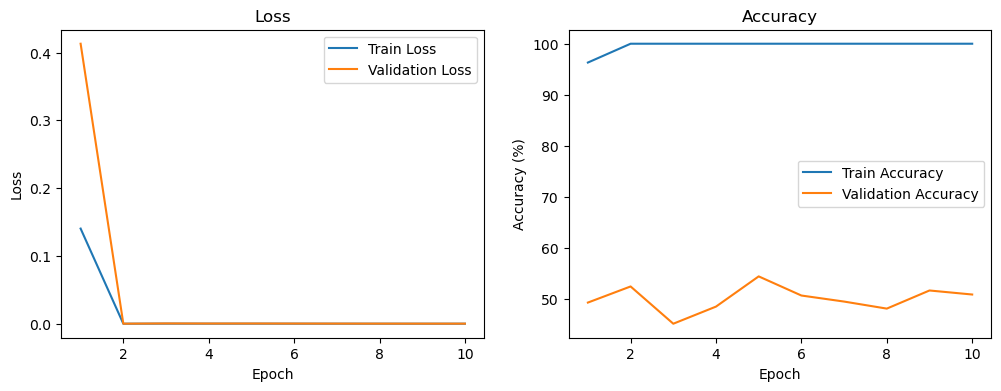

In [11]:
# On trace les courbes
epochs = range(1, num_epochs + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.savefig('training_results_bias_A_COPIER.png', format='png')

#plt.tight_layout()
plt.show()

#### **Historique d'enregistrement des modèles**

In [12]:
#torch.save(model.state_dict(), 'LeNet_bias_dropouts_1_0_1.pth')
#torch.save(model.state_dict(), 'ResNet_bias_10_epochs.pth')